#  2.1. Load the AB-test data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

df = pd.read_csv('/kaggle/input/ccookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


The data is from 90,189 players that installed the game while the AB-test was running. The variables are:

* [userid](http://) - a unique number that identifies each player.
* [version](http://) - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).
* [sum_gamerounds](http://) - the number of game rounds played by the player during the first week after install
* [retention_1](http://) - did the player come back and play 1 day after SEE THE GATE?
* [retention_7](http://) - did the player come back and play 7 days after SEE THE GATE?
* When a player installed the game, he or she was randomly assigned to either [gate_30](http://) or [gate_40](http://).

# 2.2 Check missing values

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


Luckily, there is no missing value in this dataset.

# 2.3 Count the number of players in each group

In [3]:
df.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40. The number of players is roughly the same in the control and test group, nice!

# Analyzing Player Behavior

We will plot a boxplot to visualize the distribution of 'sum_gamerounds', which would give us a rough idea of how many game rounds were played by a player during the first week after installing the game.

<Axes: >

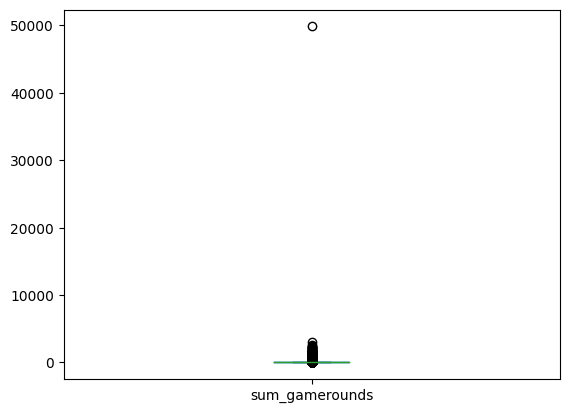

In [4]:
df['sum_gamerounds'].plot.box()

Clearly, there is an outlier. This player played about 50,000 game rounds during the first week! Due to this outlier, this boxplot is extremely skewed and not very informative. To learn about the behavior of the majority of the players, we will check the percentiles.

In [5]:
df['sum_gamerounds'].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

In [6]:
# Counting the number of players for each number of gamerounds
plot_df=df.groupby('sum_gamerounds')['userid'].count()
plot_df

sum_gamerounds
0        3994
1        5538
2        4606
3        3958
4        3629
         ... 
2294        1
2438        1
2640        1
2961        1
49854       1
Name: userid, Length: 942, dtype: int64

As we can see, 50% of players played fewer than 16 game rounds during the first week after installation, and 75% of players played fewer than 51 rounds.

Nearly 4000 players did not even play a single round after installation. Possible reasons may include:

They downloaded a number of new games at the same time and were attracted by other games.
They opened the app but did not like the design/interface/music, so they quit even before playing the game.
They have not started playing the game yet.
......
Another number worth attention is that more than 14,000 players played fewer than three rounds. For these players, the reasons for leaving may include:

They did not enjoy the game. (This is probably the most common reason).
The game turned out to be different from what they expected.
The game was too easy and they got bored of it.
......
It is important to understand why a large number of players quit the game at an early stage. Tactile Entertainment can try to collect player feedback, for example, through an in-app survey.

Text(0.5, 0, '# Game rounds')

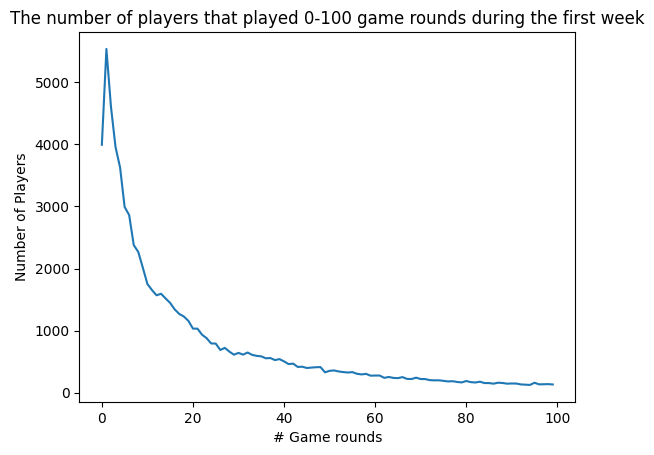

In [7]:
# Plot the distribution of players that played 0 to 100 game rounds during their first week playing the game.
%matplotlib inline

ax = plot_df[:100].plot()
ax.set_title("The number of players that played 0-100 game rounds during the first week")
ax.set_ylabel("Number of Players")
ax.set_xlabel('# Game rounds')

The distribution is highly skewed, with a long tail on the right. A huge number of players played fewer than 20 rounds and left the game. For rounds greater than 60, the number of players stayed steady at about 300.

# Customer Segmentation

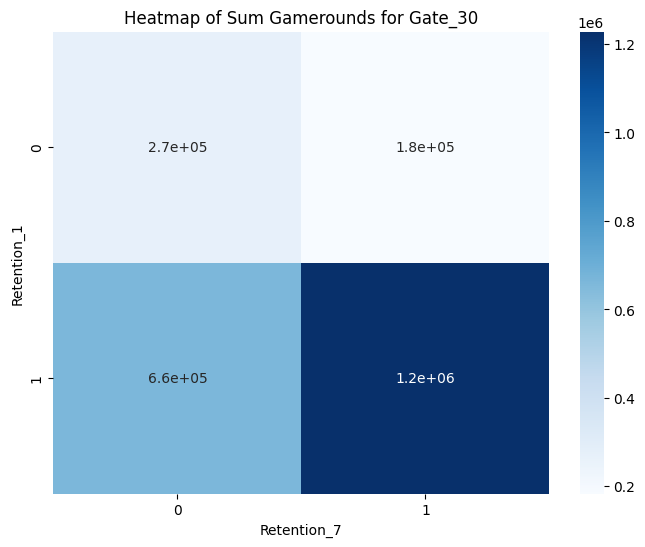

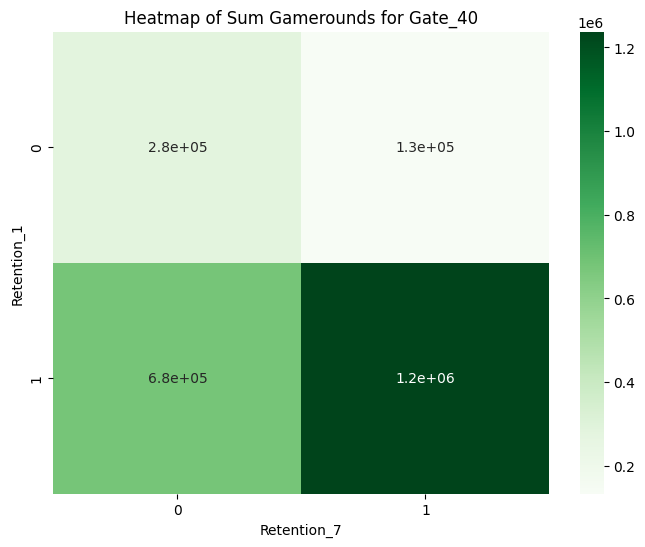

In [8]:
# correlation analysis on sum_gamerounds
import seaborn as sns
# Convert booleans to integers for easier aggregation
df['retention_1'] = df['retention_1'].astype(int)
df['retention_7'] = df['retention_7'].astype(int)

# Filter data for gate_30 and gate_40 separately
df_gate_30 = df[df['version'] == 'gate_30']
df_gate_40 = df[df['version'] == 'gate_40']

# Pivot table for gate_30
pivot_gate_30 = pd.pivot_table(df_gate_30, values='sum_gamerounds', 
                               index='retention_1', columns='retention_7', 
                               aggfunc='sum')

# Pivot table for gate_40
pivot_gate_40 = pd.pivot_table(df_gate_40, values='sum_gamerounds', 
                               index='retention_1', columns='retention_7', 
                               aggfunc='sum')

# Plotting the heatmap for gate_30
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_gate_30, annot=True, cmap='Blues')
plt.title('Heatmap of Sum Gamerounds for Gate_30')
plt.xlabel('Retention_7')
plt.ylabel('Retention_1')
plt.show()

# Plotting the heatmap for gate_40
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_gate_40, annot=True, cmap='Greens')
plt.title('Heatmap of Sum Gamerounds for Gate_40')
plt.xlabel('Retention_7')
plt.ylabel('Retention_1')
plt.show()

In [9]:
df['customer_group'] = df['retention_1'].astype(str) + "_" + df['retention_7'].astype(str)
df['customer_group']

0        0_0
1        1_0
2        1_0
3        0_0
4        1_1
        ... 
90184    1_0
90185    0_0
90186    1_0
90187    1_0
90188    0_0
Name: customer_group, Length: 90189, dtype: object

In [10]:
#remove outlier
df_filtered = df[df['sum_gamerounds'] <= 10000]
df_filtered

,userid,version,sum_gamerounds,retention_1,retention_7,customer_group
0,116,gate_30,3,0,0,0_0
1,337,gate_30,38,1,0,1_0
2,377,gate_40,165,1,0,1_0
3,483,gate_40,1,0,0,0_0
4,488,gate_40,179,1,1,1_1
...,...,...,...,...,...,...
90184,9999441,gate_40,97,1,0,1_0
90185,9999479,gate_40,30,0,0,0_0
90186,9999710,gate_30,28,1,0,1_0
90187,9999768,gate_40,51,1,0,1_0


/tmp/ipykernel_17/4218035567.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['retention_1'] = df_filtered['retention_1'].astype(int)
/tmp/ipykernel_17/4218035567.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['retention_7'] = df_filtered['retention_7'].astype(int)
/tmp/ipykernel_17/4218035567.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

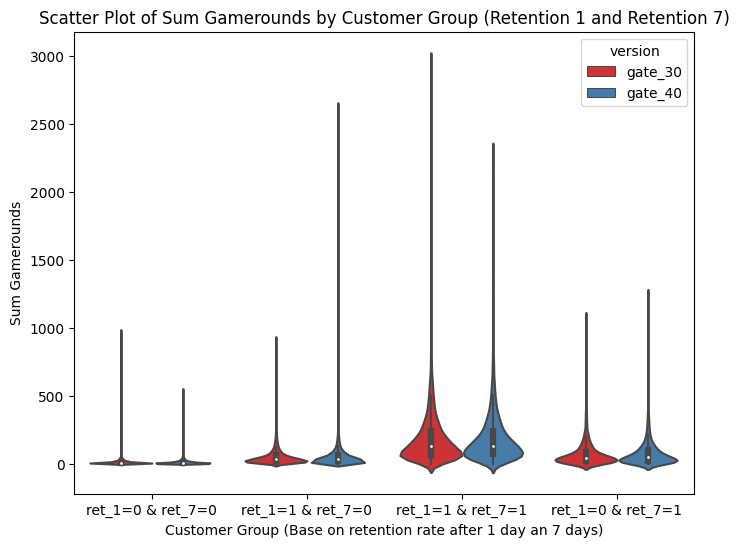

In [11]:
# Customer Segmentation
# Convert booleans to integers for easier grouping
df_filtered['retention_1'] = df_filtered['retention_1'].astype(int)
df_filtered['retention_7'] = df_filtered['retention_7'].astype(int)

# Create a new column for the four customer groups based on retention_1 and retention_7
df_filtered['customer_group'] = 'ret_1=' + df_filtered['retention_1'].astype(str) + ' & ret_7=' + df_filtered['retention_7'].astype(str)

# Plotting the scatter plot
plt.figure(figsize=(8, 6))
sns.violinplot(data=df_filtered, x='customer_group', y='sum_gamerounds', hue='version', palette='Set1')

# Adding titles and labels
plt.title('Scatter Plot of Sum Gamerounds by Customer Group (Retention 1 and Retention 7)')
plt.xlabel('Customer Group (Base on retention rate after 1 day an 7 days)')
plt.ylabel('Sum Gamerounds')

plt.show()

# Comparing 1-day Retention

In the plot above we can see that some players install the game but then never play it, some players just play a couple of game rounds in their first week, and some get really hooked! What we want is for players to like the game and to get hooked.

A common metric in the video gaming industry for how fun and engaging a game is 1-day retention: the percentage of players that comes back and plays the game one day after they have installed it. The higher 1-day retention is, the easier it is to retain players and build a large player base.

**Overall 1-day retention**

In [12]:
df['retention_1'].sum()/df['retention_1'].count()

0.4452095044850259

A little less than half of the players come back one day after installing the game. Now that we have a benchmark, let's look at how 1-day retention differs between the two AB-groups.

**1-day retention for each AB-group**

In [13]:
df.groupby('version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

It appears that there was a slight decrease in 1-day retention when the gate was moved to level 40 (44.2%) compared to the control when it was at level 30 (44.8%). It's a small change, but even small changes in retention can have a large impact. But while we are certain of the difference in the data, how certain should we be that a gate at level 40 will be worse in the future?

There are a couple of ways we can get at the certainty of these retention numbers. Here we will use bootstrapping: We will repeatedly re-sample our dataset (with replacement) and calculate 1-day retention for those samples. The variation in 1-day retention will give us an indication of how uncertain the retention numbers are.

# Methond1: Bootstrapping

**Retention_1**

In [14]:
df.sample(frac = 1,replace = True)

,userid,version,sum_gamerounds,retention_1,retention_7,customer_group
83624,9267850,gate_30,134,1,0,1_0
87606,9705229,gate_30,69,1,0,1_0
81074,8977981,gate_40,151,1,0,1_0
75485,8359398,gate_30,24,1,0,1_0
62577,6933081,gate_40,2,0,0,0_0
...,...,...,...,...,...,...
16017,1778793,gate_30,20,1,0,1_0
42398,4689837,gate_40,9,0,0,0_0
21705,2416554,gate_40,61,1,1,1_1
87570,9701131,gate_40,27,1,1,1_1


In [15]:
df.sample(frac=1,replace=True).groupby('version')['retention_1'].mean()

version
gate_30    0.449637
gate_40    0.442525
Name: retention_1, dtype: float64

<Axes: ylabel='Density'>

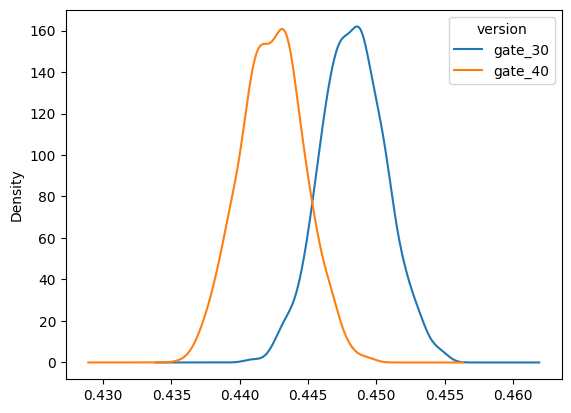

In [16]:
# Creating an list with bootstrapped means for each AB-group
boot_1=[]
for i in range(1000):
    sample= df.sample(frac=1,replace=True).groupby('version')['retention_1'].mean()
    boot_1.append(sample)
# Transforming the list to a DataFrame
boot_1 = pd.DataFrame(boot_1)
# A Kernel Density Estimate plot of the bootstrap distributions
boot_1.plot(kind='density')


These two distributions above represent the bootstrap uncertainty over what the underlying 1-day retention could be for the two AB-groups. There seems to be some evidence of a difference, albeit small. Let's plot the % difference to have a closer look.

Probability that 1-day retention is greater when the gate is at level 30: 0.96


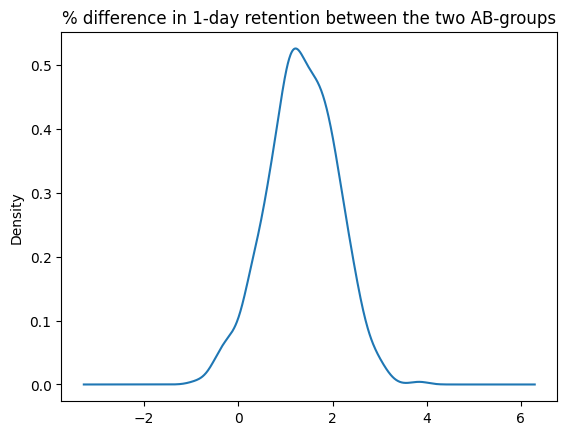

In [17]:
# Adding a column with the % difference between the two AB-groups
boot_1['diff']=(boot_1['gate_30']-boot_1['gate_40'])/boot_1['gate_40']*100

# Ploting the bootstrap % difference
ax = boot_1['diff'].plot(kind='density')
ax.set_title('% difference in 1-day retention between the two AB-groups')

# Calculating the probability that 1-day retention is greater when the gate is at level 30
print('Probability that 1-day retention is greater when the gate is at level 30:',(boot_1['diff'] > 0).mean())

From this chart, we can see that the most likely % difference is around 1% - 2%, and that 96% of the distribution is above 0%, in favor of a gate at level 30.

**Retention_7**

<Axes: ylabel='Density'>

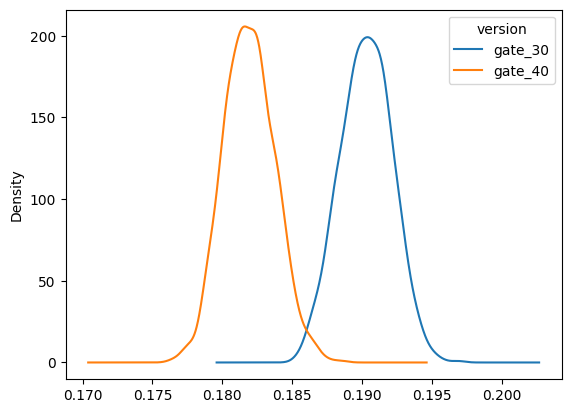

In [18]:
boot_7=[]
for i in range(1000):
    sample=df.sample(frac=1,replace=True).groupby('version')['retention_7'].mean()
    boot_7.append(sample)
boot_7=pd.DataFrame(boot_7)
boot_7.plot(kind='density')

In [19]:
boot_7

version,gate_30,gate_40
retention_7,0.188733,0.183083
retention_7,0.190959,0.184599
retention_7,0.192140,0.183205
retention_7,0.186064,0.181613
retention_7,0.192526,0.179423
...,...,...
retention_7,0.191258,0.178801
retention_7,0.190038,0.183203
retention_7,0.190684,0.179668
retention_7,0.190393,0.179309


Probability that 7-day retention is greater when the gate is at level 30: 1.0


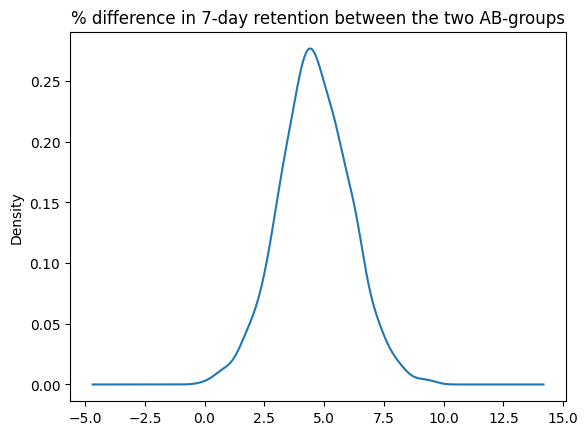

In [20]:
boot_7['diff']=(boot_7['gate_30']-boot_7['gate_40'])/boot_7['gate_40']*100
ax=boot_7['diff'].plot(kind='density')
ax.set_title('% difference in 7-day retention between the two AB-groups')

print('Probability that 7-day retention is greater when the gate is at level 30:',(boot_7['diff']>0).mean())

The bootstrap result tells us that there is strong evidence that 7-day retention is higher when the gate is at level 30 than when it is at level 40. The conclusion is: If we want to keep retention high — both 1-day and 7-day retention — we should not move the gate from level 30 to level 40.

There are, of course, other metrics we could look at, like the number of game rounds played or how much in-game purchases are made by the two AB-groups. But retention is one of the most important metrics. If we don't retain our player base, it doesn't matter how much money they spend in-game.

So, why is retention higher when the gate is positioned earlier? One could expect the opposite: The later the obstacle, the longer people are going to engage with the game. But this is not what the data tells us. The theory of hedonic adaptation can give one explanation for this.

In short, hedonic adaptation is the tendency for people to get less and less enjoyment out of a fun activity over time if that activity is undertaken continuously. By forcing players to take a break when they reach a gate, their enjoyment of the game is prolonged. But when the gate is moved to level 40, fewer players make it far enough, and they are more likely to quit the game because they simply got bored of it.

# Method2:Z-test

Let's assume that the gate_30 does not have higher conversion rate than the gate_40 at 5% Type II error. So the hypothesis woule be:

null: 𝑝𝑛𝑒𝑤 - 𝑝𝑜𝑙𝑑 <=0

alternative: 𝑝𝑛𝑒𝑤 - 𝑝𝑜𝑙𝑑 >0

**Retention_1**

In [21]:
from scipy.stats import norm
import statsmodels.api as sm

In [22]:
# Sample sizes and proportions for gate_30 and gate_40
n_gate_30 = df[df['version'] == 'gate_30'].shape[0]  # Number of samples in gate_30
n_gate_40 = df[df['version'] == 'gate_40'].shape[0]  # Number of samples in gate_40

# Proportions of retention_7 for gate_30 and gate_40
p_gate_30 = df[df['version'] == 'gate_30']['retention_1'].mean()  # Proportion for gate_30
p_gate_40 = df[df['version'] == 'gate_40']['retention_1'].mean()  # Proportion for gate_40

# Pooled proportion
p_pooled = (p_gate_30 * n_gate_30 + p_gate_40 * n_gate_40) / (n_gate_30 + n_gate_40)

# Z-score calculation
z_score = (p_gate_30 - p_gate_40) / np.sqrt(p_pooled * (1 - p_pooled) * (1/n_gate_30 + 1/n_gate_40))

# Calculate the one-tailed p-value (right-tailed)
p_value = 1 - norm.cdf(z_score)

print(f"Z-Score: {z_score}")
print(f"Retention_1 P-Value: {p_value}")

Z-Score: 1.7840862247974725
Retention_1 P-Value: 0.03720482764845956


p-value is less than 0.05, so we can reject null hypothesis and accept alternative hypothesis that 𝑝𝑛𝑒𝑤 - 𝑝𝑜𝑙𝑑 >0,the gate_30 is better than gate_40

**Retention_7**

In [23]:
retention_30=df[df.version=='gate_30'].retention_7.sum()
retention_40=df[df.version=='gate_40'].retention_7.sum()
n_30=len(df[df.version=='gate_30'].retention_7)
n_40=len(df[df.version=='gate_40'].retention_7)
retention_30,retention_40,n_30,n_40

(8502, 8279, 44700, 45489)

In [24]:
retention_30,retention_40,n_30,n_40

(8502, 8279, 44700, 45489)

In [25]:
conversion_dic={'Views':{'gate30':n_30,'gate40':n_40},'Converts':{'gate30':retention_30,'gate40':retention_40}}
conversion_table = pd.DataFrame(conversion_dic)
conversion_table['Conversion %'] = conversion_table['Converts'] / conversion_table['Views']
conversion_table['Conversion %'] = conversion_table['Conversion %'].apply(lambda x: str(np.round(x,3)*100)+'%')
conversion_table

,Views,Converts,Conversion %
gate30,44700,8502,19.0%
gate40,45489,8279,18.2%


In [26]:
def z_test(p1,p0,n1,n0):
    delta = p1-p0
    std = (p1*n1 + p0*n0) / (n1+n0)
    return delta / np.sqrt(std*(1-std)*(1/n1 + 1/n0))

In [27]:
p1 = retention_30 / n_30
p0 = retention_40/ n_40
n1 = n_30
n0 = n_40

In [28]:
z_value = z_test(p1,p0,n1,n0)
z_value

3.164358912748191

In [29]:
p_value = 1- norm.cdf(z_value)
p_value

0.0007771249878071318

In [30]:
# Sample sizes and proportions for gate_30 and gate_40
n_gate_30 = df[df['version'] == 'gate_30'].shape[0]  # Number of samples in gate_30
n_gate_40 = df[df['version'] == 'gate_40'].shape[0]  # Number of samples in gate_40

# Proportions of retention_7 for gate_30 and gate_40
p_gate_30 = df[df['version'] == 'gate_30']['retention_7'].mean()  # Proportion for gate_30
p_gate_40 = df[df['version'] == 'gate_40']['retention_7'].mean()  # Proportion for gate_40

# Pooled proportion
p_pooled = (p_gate_30 * n_gate_30 + p_gate_40 * n_gate_40) / (n_gate_30 + n_gate_40)

# Z-score calculation
z_score = (p_gate_30 - p_gate_40) / np.sqrt(p_pooled * (1 - p_pooled) * (1/n_gate_30 + 1/n_gate_40))

# Calculate the p-value 
p_value =1 - norm.cdf(np.abs(z_score))

print(f"Z-Score: {z_score}")
print(f"Retention_7 P-Value: {p_value}")

Z-Score: 3.164358912748191
Retention_7 P-Value: 0.0007771249878071318


p-value is less than 0.05, so we can reject null hypothesis and accept alternative hypothesis that 𝑝𝑛𝑒𝑤 - 𝑝𝑜𝑙𝑑 >0,the gate_30 is better than gate_40

# Z-test in Statsmodels

**Retention_1**

In [31]:
retention_30_1=df[df.version=='gate_30'].retention_1.sum()
retention_40_1=df[df.version=='gate_40'].retention_1.sum()
n_30_1=len(df[df.version=='gate_30'].retention_1)
n_40_1=len(df[df.version=='gate_40'].retention_1)
retention_30_1,retention_40_1,n_30_1,n_40_1

(20034, 20119, 44700, 45489)

In [32]:
import statsmodels.api as sm

In [33]:
z_score, p_value = sm.stats.proportions_ztest([retention_30_1, retention_40_1], [n_30_1, n_40_1], alternative='larger')
z_score, p_value

(1.7840862247974725, 0.03720482764845957)

**Retention_7**

In [34]:
retention_30_7=df[df.version=='gate_30'].retention_7.sum()
retention_40_7=df[df.version=='gate_40'].retention_7.sum()
n_30_7=len(df[df.version=='gate_30'].retention_7)
n_40_7=len(df[df.version=='gate_40'].retention_7)
retention_30_7,retention_40_7,n_30_7,n_40_7

(8502, 8279, 44700, 45489)

In [35]:
z_score, p_value = sm.stats.proportions_ztest([retention_30_7, retention_40_7],[n_30_7, n_40_7], alternative='larger')
z_score, p_value

(3.164358912748191, 0.0007771249878071645)